# **Alura Challenge Data Science - Week 2 - Building Regression Models**

## **Initializing Spark Session**

In [33]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler

In [34]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Challenge Data Science 2") \
    .getOrCreate()

In [35]:
spark

## **Importing Data**

The DataFrame we are going to use is the parquet file generated in the first notebook of the challenge. You can check the parquet file [here](https://github.com/Lacerdash/Alura-Data-Science-Challenge-II/blob/main/data/parquet/part-00000-d2c1468d-1dc9-4dc4-9b60-3a7b2ceea125-c000.snappy.parquet).

In [36]:
path = 'data/parquet/part-00000-8bc019cf-aa0b-4e9e-98c7-a3ac5f08fe01-c000.snappy.parquet'
data = spark.read.parquet(path)

In [37]:
data.count()

66348

In [38]:
data.show(5)

+-----+----------+-----------+-------+--------------------+--------------------+--------+------+-------+-----------+-----------+--------+---------+----------+----------+----+-----+-------+
|floor|total_area|useful_area|toilets|            features|                  id|bedrooms|suites|ad_type|  unit_type|   use_type|car_slot| district|      zone|condominio|iptu| type|  value|
+-----+----------+-----------+-------+--------------------+--------------------+--------+------+-------+-----------+-----------+--------+---------+----------+----------+----+-----+-------+
|    3|      43.0|       43.0|      1|[Academia, Churra...|d2e3a3aa-09b5-45a...|       2|  null|  Usado|Apartamento|Residencial|       1|Paciência|Zona Oeste|     245.0|null|Venda|15000.0|
|    2|      42.0|       42.0|      1|[Churrasqueira, P...|085bab2c-87ad-452...|       2|  null|  Usado|Apartamento|Residencial|       1|Paciência|Zona Oeste|       0.0| 0.0|Venda|15000.0|
|    1|      41.0|       41.0|      1|[Portaria 24h, Co

In [39]:
data.printSchema()

root
 |-- floor: long (nullable = true)
 |-- total_area: float (nullable = true)
 |-- useful_area: float (nullable = true)
 |-- toilets: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- ad_type: string (nullable = true)
 |-- unit_type: string (nullable = true)
 |-- use_type: string (nullable = true)
 |-- car_slot: long (nullable = true)
 |-- district: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- condominio: float (nullable = true)
 |-- iptu: float (nullable = true)
 |-- type: string (nullable = true)
 |-- value: float (nullable = true)



## **Data Procesing to use Regression Models**

Machine Learning models usually do not work correctly with null data. Therefore our DataFrame still needs some changes so we can use the Regression Models.

We need to:

- Treat null and NaN data
- Treat missing data in the features and zone columns
- Transforming categorical columns into binary columns (0, 1)


### **Treating null and NaN data**

In [40]:
# Method to count the quantity of NaN and null values in each column of the DataFrame
columns = ['floor', 'total_area', 'useful_area', 'toilets','id','bedrooms','suites','ad_type','unit_type','use_type',
    'car_slot','district','zone','condominio','iptu','type','value']

data\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in columns])\
    .show()

+-----+----------+-----------+-------+---+--------+------+-------+---------+--------+--------+--------+----+----------+----+----+-----+
|floor|total_area|useful_area|toilets| id|bedrooms|suites|ad_type|unit_type|use_type|car_slot|district|zone|condominio|iptu|type|value|
+-----+----------+-----------+-------+---+--------+------+-------+---------+--------+--------+--------+----+----------+----+----+-----+
|    0|      9186|          0|      0|  0|       0|  5544|      0|        0|       0|    3008|       0|   0|      2347|7155|   0|    0|
+-----+----------+-----------+-------+---+--------+------+-------+---------+--------+--------+--------+----+----------+----+----+-----+



In [41]:
# Filling the NaN and null values with 0
data = data\
    .select('*')\
    .na\
    .fill(0)

In [42]:
# Checking if it worked
data\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in columns])\
    .show()

+-----+----------+-----------+-------+---+--------+------+-------+---------+--------+--------+--------+----+----------+----+----+-----+
|floor|total_area|useful_area|toilets| id|bedrooms|suites|ad_type|unit_type|use_type|car_slot|district|zone|condominio|iptu|type|value|
+-----+----------+-----------+-------+---+--------+------+-------+---------+--------+--------+--------+----+----------+----+----+-----+
|    0|         0|          0|      0|  0|       0|     0|      0|        0|       0|       0|       0|   0|         0|   0|   0|    0|
+-----+----------+-----------+-------+---+--------+------+-------+---------+--------+--------+--------+----+----------+----+----+-----+



### **Treating missing data in the zone columns**

Removing empty values

In [43]:
data\
    .select('zone')\
    .groupby('zone')\
    .count()\
    .orderBy('count', ascending = False)\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Oeste|32879|
|    Zona Sul|20471|
|  Zona Norte|11853|
|Zona Central| 1134|
|            |   11|
+------------+-----+



We are going to remove these 11 rows with empty values in the column zone, since they are irrelevant.

In [44]:
data = data\
    .where(data['zone'] != '')

### **Transforming categorical columns into binary columns (0, 1)**

In [45]:
data.show(5)

+-----+----------+-----------+-------+--------------------+--------------------+--------+------+-------+-----------+-----------+--------+---------+----------+----------+----+-----+-------+
|floor|total_area|useful_area|toilets|            features|                  id|bedrooms|suites|ad_type|  unit_type|   use_type|car_slot| district|      zone|condominio|iptu| type|  value|
+-----+----------+-----------+-------+--------------------+--------------------+--------+------+-------+-----------+-----------+--------+---------+----------+----------+----+-----+-------+
|    3|      43.0|       43.0|      1|[Academia, Churra...|d2e3a3aa-09b5-45a...|       2|     0|  Usado|Apartamento|Residencial|       1|Paciência|Zona Oeste|     245.0| 0.0|Venda|15000.0|
|    2|      42.0|       42.0|      1|[Churrasqueira, P...|085bab2c-87ad-452...|       2|     0|  Usado|Apartamento|Residencial|       1|Paciência|Zona Oeste|       0.0| 0.0|Venda|15000.0|
|    1|      41.0|       41.0|      1|[Portaria 24h, Co

We have filtered the DataFrame in the notebook [1 - Extract, Transfrom and Load](), because of that the columns `ad_type`, `unit_type`, `use_type` and `type` have unique values. 

Therefore we will not have to tranform these columns into binary, nor we will use it in our model (we will remove them after), since they will not influence our target variable (value).

Howerever, there are still two columns we can transform into binary: `features` and `zone`

#### *features columns*

In [46]:
data.show()

+-----+----------+-----------+-------+--------------------+--------------------+--------+------+-------+-----------+-----------+--------+--------------------+----------+----------+----+-----+-------+
|floor|total_area|useful_area|toilets|            features|                  id|bedrooms|suites|ad_type|  unit_type|   use_type|car_slot|            district|      zone|condominio|iptu| type|  value|
+-----+----------+-----------+-------+--------------------+--------------------+--------+------+-------+-----------+-----------+--------+--------------------+----------+----------+----+-----+-------+
|    3|      43.0|       43.0|      1|[Academia, Churra...|d2e3a3aa-09b5-45a...|       2|     0|  Usado|Apartamento|Residencial|       1|           Paciência|Zona Oeste|     245.0| 0.0|Venda|15000.0|
|    2|      42.0|       42.0|      1|[Churrasqueira, P...|085bab2c-87ad-452...|       2|     0|  Usado|Apartamento|Residencial|       1|           Paciência|Zona Oeste|       0.0| 0.0|Venda|15000.0|


In [47]:
# Source: https://stackoverflow.com/questions/48767861/multilabelbinarizer-in-spark

labels_set = data\
        .withColumn('exploded', f.explode('features'))\
        .agg(f.collect_set('exploded'))\
        .collect()[0][0]
labels_set = sorted(labels_set) # Getting the unique values inside the features column

for i in labels_set: # Creating a column for each unique feature if a "when" clause to assign 1 when the array of that row contains the unique values from "labels_set"
        data = data.withColumn(i, f.when(f.array_contains('features', i), 1).otherwise(0)) 

binary_data = data.drop('features') # Dropping features columns

In [48]:
binary_data.show(2)

+-----+----------+-----------+-------+--------------------+--------+------+-------+-----------+-----------+--------+---------+----------+----------+----+-----+-------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|floor|total_area|useful_area|toilets|                  id|bedrooms|suites|ad_type|  unit_type|   use_type|car_slot| district|      zone|condominio|iptu| type|  value|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+-----+----------+-----------+-------+--------------------+--------+------+-------+-----------+-----------+--------+---------+----------+----------+----+-----+-------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|    3|      43.0|       43.0|      1|d2e3a3aa-09b5-45a...|       2|     0|  Usado|Apart

In [49]:
features_new_columns_translation = { 
 'Academia' : 'gym',
 'Animais permitidos' : 'animals_allowed',
 'Churrasqueira': 'barbecue_grill',
 'Condomínio fechado' : 'gated_community',
 'Elevador' : 'elevator',
 'Piscina' : 'pool',
 'Playground' : 'playground',
 'Portaria 24h' : '24h_Concierge',
 'Portão eletrônico' : 'electronic_gate',
 'Salão de festas': 'party_room'
}

In [50]:
# Changing columns names
for key, value in features_new_columns_translation.items():
    binary_data = binary_data.withColumnRenamed(key, value)

In [51]:
binary_data.show(5)

+-----+----------+-----------+-------+--------------------+--------+------+-------+-----------+-----------+--------+---------+----------+----------+----+-----+-------+---+---------------+--------------+---------------+--------+----+----------+-------------+---------------+----------+
|floor|total_area|useful_area|toilets|                  id|bedrooms|suites|ad_type|  unit_type|   use_type|car_slot| district|      zone|condominio|iptu| type|  value|gym|animals_allowed|barbecue_grill|gated_community|elevator|pool|playground|24h_Concierge|electronic_gate|party_room|
+-----+----------+-----------+-------+--------------------+--------+------+-------+-----------+-----------+--------+---------+----------+----------+----+-----+-------+---+---------------+--------------+---------------+--------+----+----------+-------------+---------------+----------+
|    3|      43.0|       43.0|      1|d2e3a3aa-09b5-45a...|       2|     0|  Usado|Apartamento|Residencial|       1|Paciência|Zona Oeste|     245

We can see that our code succesfully transformed the features column into binary column. Where each new column created `('gym', 'barbecue_grill', 'animals_allowed', 'gated_community', 'elevator', 'pool',    'playground', '24h_Concierge', 'electronic gate', 'party_room', 'party_room')` represent a feature from the real estate.

In [52]:
# Fix the vizualization of SparkDataFrame in VSCODE
from IPython.core.display import HTML

HTML("""<style>
    .output-plaintext, .output-stream, .output{
        white-space: pre !important;
        font-family: Monaco; # Any monospaced font should work
    }</style>""")

#### *zone column*

In [53]:
binary_data\
    .select('zone')\
    .groupby('zone')\
    .count()\
    .orderBy('count', ascending = False)\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Oeste|32879|
|    Zona Sul|20471|
|  Zona Norte|11853|
|Zona Central| 1134|
+------------+-----+



In [54]:
zone = binary_data\
    .groupBy("id")\
    .pivot('zone')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [55]:
zone.show(5)

+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|           0|         1|         0|       0|
|3dd5d200-0a7f-43d...|           0|         0|         0|       1|
|82707939-71bd-40c...|           0|         0|         0|       1|
+--------------------+------------+----------+----------+--------+
only showing top 5 rows



In [56]:
# Making a inner join to join the binary columns generated from the zone column
binary_data_1 = binary_data\
    .join(zone, 'id', how='inner')

binary_data_1 = binary_data_1.drop('zone') # Dropping the zone column

In [57]:
features_new_columns_translation = { 
'Zona Central' : 'central_zone',
'Zona Norte' : 'north_zone',
'Zona Oeste' : 'west_zone',
'Zona Sul' : 'south_zone'
}

In [58]:
# Changing columns names
for key, value in features_new_columns_translation.items():
    binary_data_1 = binary_data_1.withColumnRenamed(key, value)

binary_data_1.show(5)

+--------------------+-----+----------+-----------+-------+--------+------+-------+-----------+-----------+--------+-----------+----------+------+-----+---------+---+---------------+--------------+---------------+--------+----+----------+-------------+---------------+----------+------------+----------+---------+----------+
|                  id|floor|total_area|useful_area|toilets|bedrooms|suites|ad_type|  unit_type|   use_type|car_slot|   district|condominio|  iptu| type|    value|gym|animals_allowed|barbecue_grill|gated_community|elevator|pool|playground|24h_Concierge|electronic_gate|party_room|central_zone|north_zone|west_zone|south_zone|
+--------------------+-----+----------+-----------+-------+--------+------+-------+-----------+-----------+--------+-----------+----------+------+-----+---------+---+---------------+--------------+---------------+--------+----+----------+-------------+---------------+----------+------------+----------+---------+----------+
|4e47e4d4-3326-4eb...|   

### **Removing useless columns**

Columns with unique values ``('id', 'ad_type', 'unit_type', 'use_type', 'type')`` are useless to our model, therefore we will remove them from our DataFrame.

We are going to remove the `district` column since it will not be useful to our analysis.

And we are also going to remove the `total_are` colum, since it has more null values then the `useful_area` column and both columns have similar data.

In [59]:
features_selection_DF = binary_data_1.drop('id', 'ad_type', 'unit_type', 'use_type', 'type', 'district', 'total_area')
features_selection_DF.show(5)

+-----+-----------+-------+--------+------+--------+----------+------+---------+---+---------------+--------------+---------------+--------+----+----------+-------------+---------------+----------+------------+----------+---------+----------+
|floor|useful_area|toilets|bedrooms|suites|car_slot|condominio|  iptu|    value|gym|animals_allowed|barbecue_grill|gated_community|elevator|pool|playground|24h_Concierge|electronic_gate|party_room|central_zone|north_zone|west_zone|south_zone|
+-----+-----------+-------+--------+------+--------+----------+------+---------+---+---------------+--------------+---------------+--------+----+----------+-------------+---------------+----------+------------+----------+---------+----------+
|    0|       90.0|      2|       3|     1|       0|     950.0|2677.0| 949020.0|  0|              0|             0|              0|       1|   0|         0|            0|              0|         0|           0|         0|        0|         1|
|    3|       64.0|      1| 

### **Saving the processed DataFrame**

In this project, we created an ideal database to use in machine learning models. It is important to export it to be able to use it in other models and to retrain our model, if necessary.


In [ ]:
features_selection_DF.write.parquet(
    path = 'data/parquet_processed_data',
    mode = 'overwrite'
)

## **Creating Models**

### **Vectorizing the data (Vector Assembler)**

In [61]:
# Nomenclature that spark expects for the variable that we are going to predict
dataset = features_selection_DF.withColumnRenamed('value','label')

In [62]:
# delecting the features
X = ['floor',
 'useful_area',
 'toilets',
 'bedrooms',
 'suites',
 'car_slot',
 'condominio',
 'iptu',
 'gym',
 'animals_allowed',
 'barbecue_grill',
 'gated_community',
 'elevator',
 'pool',
 'playground',
 '24h_Concierge',
 'electronic_gate',
 'party_room',
 'central_zone',
 'north_zone',
 'west_zone',
 'south_zone']

In [63]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [64]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [65]:
dataset_prep.show(10, truncate = False)

+----------------------------------------------------------------------------------------------------+---------+
|features                                                                                            |label    |
+----------------------------------------------------------------------------------------------------+---------+
|(22,[1,2,3,4,6,7,12,21],[90.0,2.0,3.0,1.0,950.0,2677.0,1.0,1.0])                                    |949020.0 |
|[3.0,64.0,1.0,2.0,2.0,1.0,784.0,80.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]       |380000.0 |
|(22,[1,2,3,4,5,6,7,10,11,12,13,19],[82.0,2.0,3.0,1.0,1.0,1515.0,133.0,1.0,1.0,1.0,1.0,1.0])         |580000.0 |
|(22,[1,2,3,4,5,6,7,12,21],[170.0,3.0,4.0,1.0,1.0,2250.0,3000.0,1.0,1.0])                            |1450000.0|
|(22,[1,2,3,4,5,6,7,21],[525.0,4.0,4.0,2.0,2.0,5000.0,2100.0,1.0])                                   |5199000.0|
|[0.0,50.0,1.0,2.0,0.0,1.0,320.0,80.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0]  

### **Plotting the Correlation Matrix**

In [66]:
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
correlacao = Correlation.correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]

dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns = X, index = X)

<AxesSubplot:>

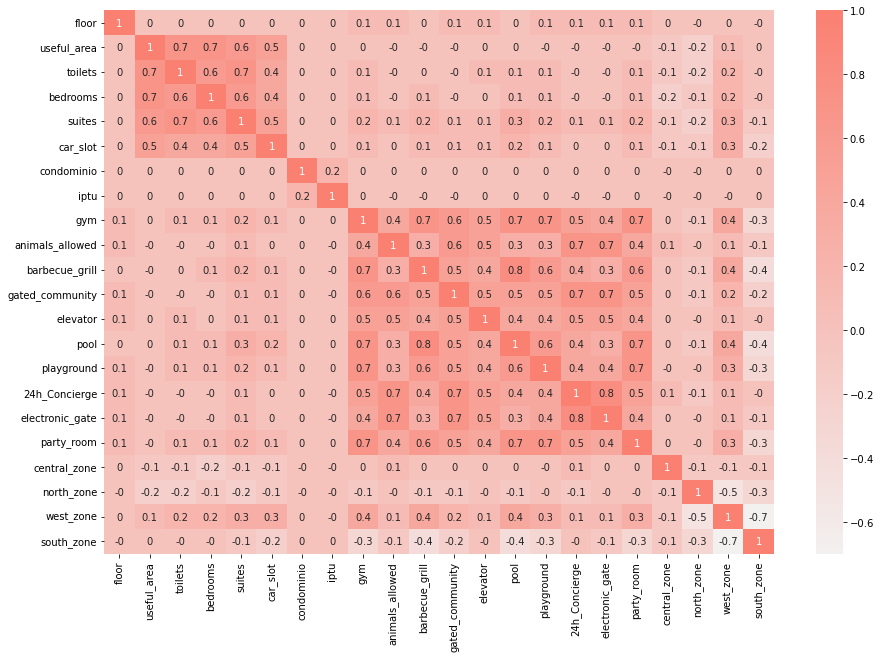

In [68]:
plt.figure(figsize=(15, 10))
paleta = sns.color_palette('light:salmon', as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

### **Linear Regression Model**

#### *Creating and Training the Model*

In [71]:
from pyspark.ml.regression import LinearRegression

In [70]:
# Divinding the Dataset into train and test (70%, 30%)
train, test = dataset_prep.randomSplit([0.7, 0.3], seed=50)

print('The train dataset has {} register, and the test dataset has {}'.format(train.count(), test.count()))

The train dataset has 46319 register, and the test dataset has 20018


In [76]:
# Creating the Model
lr = LinearRegression()

# Training the LinearRegression Model with the train dataset
lr_model = lr.fit(train)

# Using the trained model to predict the label from the train dataset
predictions_lr_train = lr_model.transform(train)

predictions_lr_train.show(5)

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...|3050000.0| 3646559.581668706|
|(22,[0,1,2,3,4,5,...|1600000.0| 2816016.587696718|
|(22,[0,1,2,3,4,5,...|4500000.0| 6329347.122669879|
|(22,[0,1,2,3,4,5,...|4104228.0|1949955.9439401114|
|(22,[0,1,2,3,4,5,...|1390000.0| 2384500.832475532|
+--------------------+---------+------------------+
only showing top 5 rows



#### *Calculating Metrics to evaluate the model*

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(predictions_lr_train, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(predictions_lr_train, {evaluator.metricName: "rmse"}))

In [106]:
# Using the trained model to predict the label for the test dataset
predictions_lr_test = lr_model.transform(test)
predictions_lr_test.show(5)

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...|3390000.0|2740999.7600770565|
|(22,[0,1,2,3,4,5,...|1800000.0|2149338.1337927165|
|(22,[0,1,2,3,4,5,...| 620000.0|1047282.5821635765|
|(22,[0,1,2,3,4,5,...| 960000.0|1433135.7834619465|
|(22,[0,1,2,3,4,5,...|1580000.0| 1831077.919211316|
+--------------------+---------+------------------+
only showing top 5 rows



In [ ]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_lr_train, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_lr_train, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_lr_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_lr_test, {evaluator.metricName: "rmse"}))

### **Decision Tree Regressor**

#### *Creating and Training the Model*

In [86]:
from pyspark.ml.regression import DecisionTreeRegressor

In [90]:
dtr = DecisionTreeRegressor(seed=50, maxDepth=7)

In [107]:
# Training the LinearRegression Model with the train dataset
dtr_model = dtr.fit(train)

# Using the trained model to predict the label from the train dataset
predictions_dtr_train = dtr_model.transform(train)

predictions_dtr_train.show(5)

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...|3050000.0|3149319.8434343436|
|(22,[0,1,2,3,4,5,...|1600000.0|3149319.8434343436|
|(22,[0,1,2,3,4,5,...|4500000.0| 5127119.871428572|
|(22,[0,1,2,3,4,5,...|4104228.0| 1596272.153488372|
|(22,[0,1,2,3,4,5,...|1390000.0|1596778.2566096424|
+--------------------+---------+------------------+
only showing top 5 rows



#### *Calculating Metrics to evaluate the model*

In [110]:
predictions_dtr_test = dtr_model.transform(test)

In [111]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_dtr_train, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_dtr_train, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_dtr_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_dtr_test, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.796553
RMSE: 663124.094804

Dados de Teste
R²: 0.779504
RMSE: 689897.819669


### **Random Forest Regressor**

#### *Creating and Training the Model*

In [112]:
from pyspark.ml.regression import RandomForestRegressor

In [113]:
# Creating the Model
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)

In [116]:
# Training the Random Forest Model with the train dataset
rfr_model = rfr.fit(train)

# Using the trained model to predict the label from the train dataset
predictions_rfr_train = rfr_model.transform(train)

predictions_rfr_train.show(5)

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...|3050000.0|3565326.6379570276|
|(22,[0,1,2,3,4,5,...|1600000.0|2288281.3117709314|
|(22,[0,1,2,3,4,5,...|4500000.0|3926474.1113734944|
|(22,[0,1,2,3,4,5,...|4104228.0|1712020.1159266657|
|(22,[0,1,2,3,4,5,...|1390000.0|1525884.3787311842|
+--------------------+---------+------------------+
only showing top 5 rows



#### *Calculating Metrics to evaluate the model*

In [118]:
# Using the rfr model to predict the label in the test dataset
predictions_rfr_test = rfr_model.transform(test)

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...|3390000.0|  3613186.56840553|
|(22,[0,1,2,3,4,5,...|1800000.0|1940245.9337270013|
|(22,[0,1,2,3,4,5,...| 620000.0| 945825.0851554855|
|(22,[0,1,2,3,4,5,...| 960000.0|1354495.8359083165|
|(22,[0,1,2,3,4,5,...|1580000.0|1790244.7808445513|
+--------------------+---------+------------------+
only showing top 5 rows



In [119]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_rfr_train, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_rfr_train, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_rfr_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_rfr_test, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.809518
RMSE: 641647.372493

Dados de Teste
R²: 0.794427
RMSE: 666141.667946


### **Gradient-boosted tree Regressor**

#### *Creating and Training the Model*

In [133]:
from pyspark.ml.regression import GBTRegressor

In [139]:
gbt = GBTRegressor(maxDepth=3, seed=42, leafCol="leafId")

In [140]:
gbt_model = gbt.fit(train)

predictions_gbt_train = gbt_model.transform(train)

predictions_gbt_train.show(5)

+--------------------+---------+------------------+--------------------+
|            features|    label|        prediction|              leafId|
+--------------------+---------+------------------+--------------------+
|(22,[0,1,2,3,4,5,...|3050000.0| 3747583.297297226|[5.0,3.0,3.0,6.0,...|
|(22,[0,1,2,3,4,5,...|1600000.0|2282472.8517849804|[4.0,3.0,3.0,4.0,...|
|(22,[0,1,2,3,4,5,...|4500000.0| 4116951.786360097|[5.0,6.0,6.0,5.0,...|
|(22,[0,1,2,3,4,5,...|4104228.0|  1698801.32715008|[2.0,5.0,5.0,4.0,...|
|(22,[0,1,2,3,4,5,...|1390000.0|1603430.5181170304|[1.0,5.0,6.0,4.0,...|
+--------------------+---------+------------------+--------------------+
only showing top 5 rows



#### *Calculating Metrics to evaluate the model*

In [141]:
predictions_gbt_test = gbt_model.transform(test)

In [142]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_gbt_train, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_gbt_train, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_gbt_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_gbt_test, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.777865
RMSE: 692910.271774

Dados de Teste
R²: 0.769865
RMSE: 704815.577721


## **Optimizing the best model**

As we can see the model that had the best results was the Random Forest (as expected). Now we are going to use some techniques such as, cross validation and hyperparameters testing to increase our model's metrics.

In [121]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [123]:
rfr = RandomForestRegressor()
evaluator = RegressionEvaluator()

In [128]:
# Creating our sample space for testing hyperparameters
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45]) \
    .build()

In [129]:
rfr_cv = CrossValidator(
    estimator=rfr, # The model
    estimatorParamMaps=grid, # Our grid containing the hyperparameters
    evaluator=evaluator, # Evaluating method
    numFolds=5 # the number of folds to use in cross-validation
)

In [130]:
rfr_cv_model = rfr_cv.fit(train)

In [131]:
predictions_rfr_csv_test = rfr_cv_model.transform(test)

In [132]:
print('Random Forest Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_rfr_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_rfr_test, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(predictions_rfr_csv_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predictions_rfr_csv_test, {evaluator.metricName: "rmse"}))

Random Forest Regression
Sem Cross Validation
R²: 0.794427
RMSE: 666141.667946

Com Cross Validation
R²: 0.831222
RMSE: 603589.233296


We can see that we were able to improve our model R2 metric in almost **0.04**, after we applied cross validation and hyperparameters testing in the Random Forest Regressor.